In [8]:
import string
from os import listdir
from pickle import dump
from pickle import load
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from numpy import array
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from numpy import argmax
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Input

# **Prepare Photo**

In [9]:
def extract_features(directory):
    model = VGG16()
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    
#     input_tensor = Input(shape=(224, 224, 3))
#     model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=True)
#     model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    
    features = dict()
    for name in listdir(directory):
        filename = directory + '/' + name
        image = load_img(filename, target_size=(224, 224))
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)
        feature = model.predict(image, verbose=0)
        image_id = name.split('.')[0]
        features[image_id] = feature
    return features

In [10]:
directory = '../input/vr-miniproject/Flicker8k_Images/Flicker8k_Images'
features = extract_features(directory)
print('Extracted Features: %d' % len(features))
dump(features, open('features.pkl', 'wb'))

553467904/553467096 [==============================] - 8s 0us/step
Extracted Features: 8091


# **Prepare Text**

In [11]:
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [12]:
def load_descriptions(doc):
    mapping = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        if len(line) < 2:
            continue
        image_id, image_desc = tokens[0], tokens[1:]
        image_id = image_id.split('.')[0]
        image_desc = ' '.join(image_desc)
        if image_id not in mapping:
            mapping[image_id] = list()
        mapping[image_id].append(image_desc)
    return mapping

In [13]:
def clean_descriptions(descriptions):
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            desc = desc.split()
            desc = [word.lower() for word in desc]
            desc = [w.translate(table) for w in desc]
            desc = [word for word in desc if len(word)>1]
            desc = [word for word in desc if word.isalpha()]
            desc_list[i] =  ' '.join(desc)

In [14]:
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [15]:
filename = '../input/vr-miniproject/Flickr8k_text/Flickr8k_text/Flickr8k.token.txt'
doc = load_doc(filename)
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))
clean_descriptions(descriptions)
save_descriptions(descriptions, 'descriptions.txt')

Loaded: 8092 


# **Model**

In [16]:
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    for line in doc.split('\n'):
        if len(line) < 1:
            continue
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

In [17]:
def load_clean_descriptions(filename, dataset):
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        if image_id in dataset:
            if image_id not in descriptions:
                descriptions[image_id] = list()
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            descriptions[image_id].append(desc)
    return descriptions

In [18]:
def load_photo_features(filename, dataset):
    all_features = load(open(filename, 'rb'))
    features = {k: all_features[k] for k in dataset}
    return features

In [19]:
def to_lines(descriptions):
    all_desc = list()
    count={}  
    for key in descriptions.keys(): 
        for d in descriptions[key]:
            l=d.split()
            for x in l:
                if(x not in count):
                    count[x]=0
                count[x]+=1
    for key in descriptions.keys():
        for d in descriptions[key]:
            l=d.split()
            st=[]
            for x in l:
                if(count[x]>=3):
                    st.append(x)
            s=""
            for w in st: 
                s+=w
                s+=" "
            all_desc.append(s)
    return all_desc
 
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [20]:
def maxLength(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

def create_sequences(tokenizer, max_length, desc_list, photo, vocab_size):
    X1, X2, y = list(), list(), list()
    for desc in desc_list:
        seq = tokenizer.texts_to_sequences([desc])[0]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return array(X1), array(X2), array(y)

In [21]:
def define_model(vocab_size, max_length):
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [22]:
def data_generator(descriptions, photos, tokenizer, max_length, vocab_size):
    while 1:
        for key, desc_list in descriptions.items():
            photo = photos[key][0]
            in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo, vocab_size)
            yield [in_img, in_seq], out_word

In [23]:
filename = '../input/vr-miniproject/Flickr8k_text/Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
train_descriptions = load_clean_descriptions('./descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
train_features = load_photo_features('./features.pkl', train)
print('Photos: train=%d' % len(train_features))

tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
max_len = maxLength(train_descriptions)
print('Description Length: %d' % max_len)

dump(tokenizer, open('tokenizer.pkl', 'wb'))

Dataset: 6000
Descriptions: train=6000
Photos: train=6000
Vocabulary Size: 3472
Description Length: 34


In [24]:
model = define_model(vocab_size, max_len)
epochs = 1
steps = len(train_descriptions)
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_len, vocab_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('NewModel_' + str(i) + '.h5')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 256)      888832      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 4096)         0           input_2[0][0]                    
____________________________________________________________________________________________

# **Testing**

In [25]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
 
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

In [26]:
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    for key, desc_list in descriptions.items():
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [27]:
def extract_features(filename):
    model = VGG16()
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
#     input_tensor = Input(shape=(224, 224, 3))
#     model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=True)
#     model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    
    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    return feature

In [28]:
tokenizer = load(open('./tokenizer.pkl', 'rb'))
max_length = 34

startseq man in red shirt is sitting on the street endseq


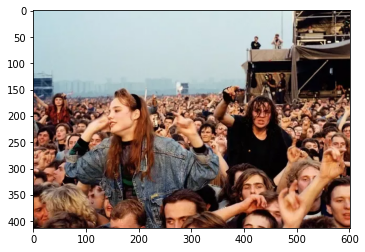

In [29]:
import matplotlib.pyplot as plt
path='../input/vr-miniproject/subjective_img/subjective_img/sample3.jpg'
model = load_model('./NewModel_0.h5')
image = load_img(path)
plt.imshow(image)
photo = extract_features(path)
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

In [30]:
filename = '../input/vr-miniproject/Flickr8k_text/Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
train_descriptions = load_clean_descriptions('./descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
max_len = maxLength(train_descriptions)
print('Description Length: %d' % max_len)
 

filename = '../input/vr-miniproject/Flickr8k_text/Flickr8k_text/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
test_descriptions = load_clean_descriptions('./descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
test_features = load_photo_features('./features.pkl', test)
print('Photos: test=%d' % len(test_features))

Dataset: 6000
Descriptions: train=6000
Vocabulary Size: 3472
Description Length: 34
Dataset: 1000
Descriptions: test=1000
Photos: test=1000


In [32]:
filename = './NewModel_0.h5'
model = load_model(filename)
evaluate_model(model, test_descriptions, test_features, tokenizer, max_len)

BLEU-1: 0.568873
BLEU-2: 0.305014
BLEU-3: 0.202131
BLEU-4: 0.085810
